In [2]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import fannypack

In [121]:
class FullCovGaussianLayer(nn.Module):
    def __init__(
        self, 
        input_dim, 
        output_dim, 
        prior_var = 0.8, 
        pre_trained_values = None
    ):
        super(FullCovGaussianLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Prior parameters p(theta)

        # If no prior parameters are given, set them to zero mean and given variance
        if pre_trained_values is None:
            self.mu_p = torch.zeros(input_dim * output_dim + output_dim)
            self.chol_p = torch.eye(input_dim * output_dim + output_dim) * torch.sqrt(torch.tensor(prior_var))
            
        else:
            w_pre_mean = pre_trained_values[0]
            w_pre_log_var = pre_trained_values[1]
            b_pre_mean = pre_trained_values[2]
            b_pre_log_var = pre_trained_values[3]
            self.mu_p = torch.cat([w_pre_mean, b_pre_mean], dim=0)
            combined_log_vars = torch.cat([w_pre_log_var, b_pre_log_var], dim=0)
            self.chol_p = torch.diag(torch.exp(combined_log_vars / 2))
           

         # Variational parameters q(theta)
        self.mu_q = self.mu_p.clone()
        self.chol_q = self.chol_p.clone()

        self.w_lambda_1 = torch.linalg.inv(self.chol_q @ self.chol_q.t()) @ self.mu_q


    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p(self):
        """Weight prior distribution"""
        return torch.distributions.MultivariateNormal(self.mu_p, scale_tril=self.chol_p)

    def q(self):
        """Variational weight posterior"""
        return torch.distributions.MultivariateNormal(self.mu_q, scale_tril=self.chol_q)

    
    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        return torch.distributions.kl_divergence(self.q(), self.p()).sum()
    
    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim
        num_samples = x.shape[0]

        # Sample the parameters and detach them from the hyperparameters graph
        param_sample = self.q().rsample((num_samples,)).detach().requires_grad_()
        weights = param_sample[:,:self.input_dim * self.output_dim]  # Shape: (num_samples, input_dim * output_dim)
        weights = weights.view(num_samples, self.input_dim, self.output_dim)  # Reshape to (num_samples, input_dim, output_dim)

        biases = param_sample[:,self.input_dim * self.output_dim:].unsqueeze(1)  # Shape: (output_dim, num_samples)

        return x @ weights + biases 




In [122]:
class RouBLBNN(nn.Module):
    """BNN with layer-wise block diagonal covariance Gaussian distributions."""
    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation = nn.ELU(),
        noise_std=1.0,
        prior_var = 0.8,
        pre_trained_values = None
    ):
        super(RouBLBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            # If no pre trained parameters are given, set them to zero mean and given variance
            if pre_trained_values is None:
                if i == 0:
                    self.network.append(FullCovGaussianLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                    self.network.append(self.activation)
                elif i == len(hidden_dims):
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                    )
                else:
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                    )
                    self.network.append(self.activation) 

            # Set to pre trained values
            else:
                if i == 0:
                    self.network.append(FullCovGaussianLayer(self.input_dim, self.hidden_dims[i], pre_trained_values = pre_trained_values[i]))
                    self.network.append(self.activation)
                elif i == len(hidden_dims):
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.output_dim, pre_trained_values = pre_trained_values[i])
                    )
                else:
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.hidden_dims[i], pre_trained_values = pre_trained_values[i])
                    )
                    self.network.append(self.activation)

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."
        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for layer in self.network:
            x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x
    
    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, self.noise_std)
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()
    
    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl_divergence() for layer in self.network if isinstance(layer, FullCovGaussianLayer)])
    
    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl

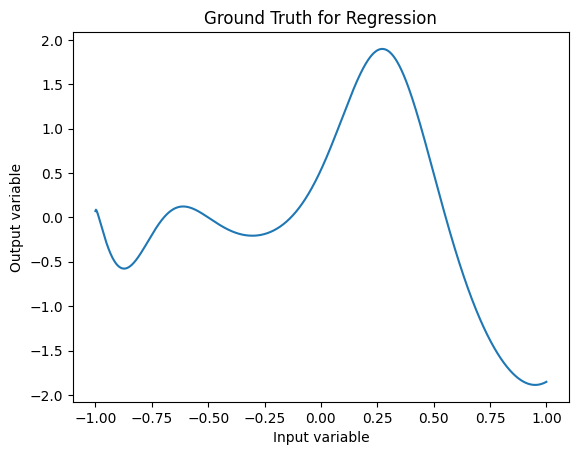

In [5]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
plt.title("Ground Truth for Regression")
plt.plot(xs, ys)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.show()

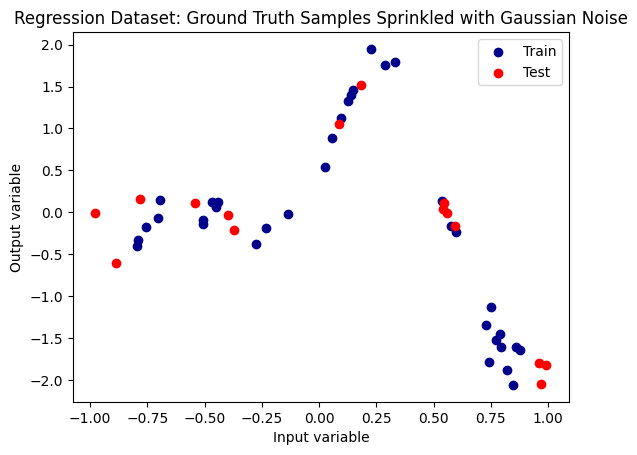

In [6]:
def generate_dataset(size=50, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)

x_tr, x_te, y_tr, y_te = generate_dataset()
plt.title("Regression Dataset: Ground Truth Samples Sprinkled with Gaussian Noise")
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

In [123]:
class MeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=5e-2, prior_var = 1):
        super(MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))

        # self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.b_mu_p = torch.zeros(output_dim)
        # self.b_log_var_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))


        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Normal(self.w_mu_q, (0.5 * self.w_log_var_q).exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Normal(self.b_mu_q, (0.5 * self.b_log_var_q).exp())

    def kl(self):
        weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
        bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
        return weight_kl + bias_kl

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).

        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        
        return x @ weights + biases # (num_samples, batch_size, output_dim).








class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.ELU(),
        noise_std=1.0,
        prior_var = 1
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
        
        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                )
            else:
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for layer in self.network:
            x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl

In [81]:
pre_train_model = MeanFieldBNN(1, [4, 4], 1, noise_std=0.15, prior_var = 0.3)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(pre_train_model)

opt = torch.optim.Adam(
    pre_train_model.parameters(),
    lr = 1e-2
)

MeanFieldBNN(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): ELU(alpha=1.0)
    (2): MeanFieldLayer()
    (3): ELU(alpha=1.0)
    (4): MeanFieldLayer()
  )
)


100%|██████████| 3000/3000 [00:53<00:00, 55.77it/s]


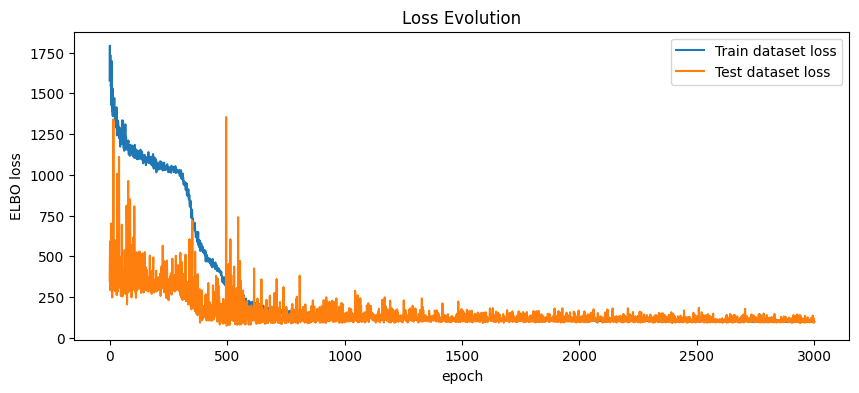

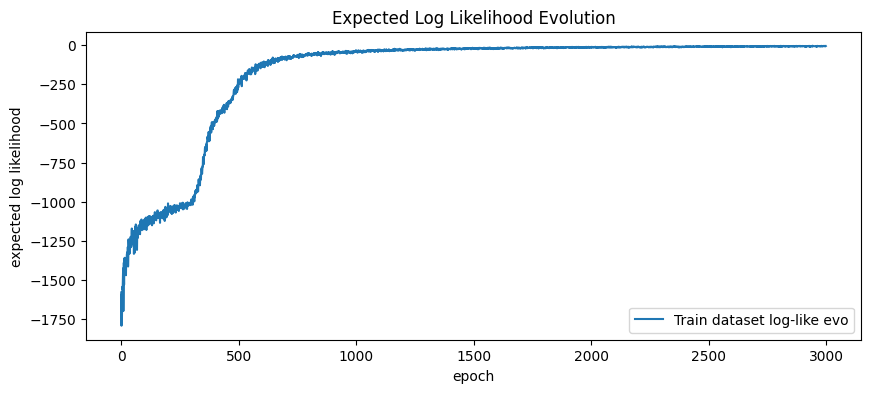

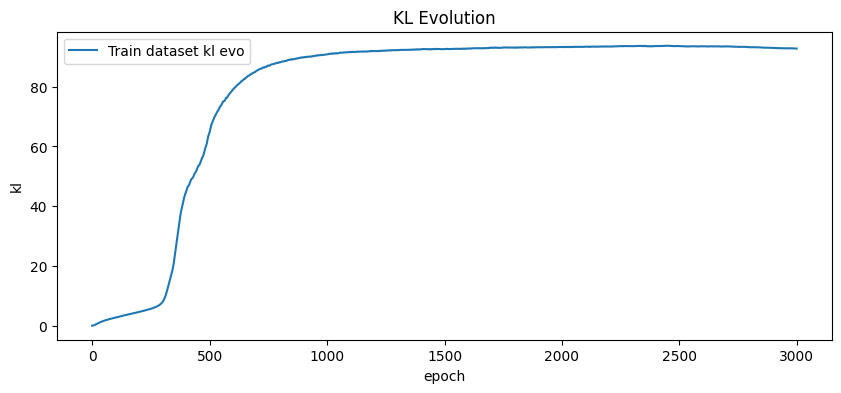

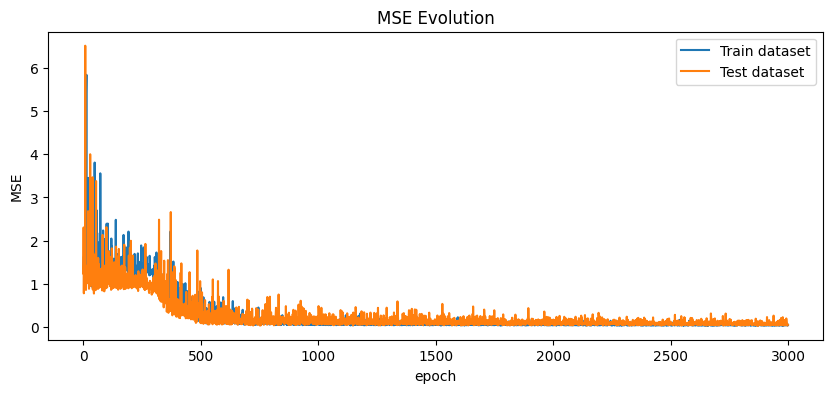

In [24]:
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

for epoch in tqdm(range(3000)):  # epochs
    opt.zero_grad()

    l, ll, kl = pre_train_model.loss(x_tr, y_tr,num_samples = 100)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(pre_train_model(x_tr), y_tr.unsqueeze(0)).item())

    te_loss_evo.append(pre_train_model.loss(x_te, y_te)[0].item())
    te_mse_loss_evo.append(aux_loss(pre_train_model(x_te), y_te.unsqueeze(0)).item())

    l.backward()
    opt.step()

plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

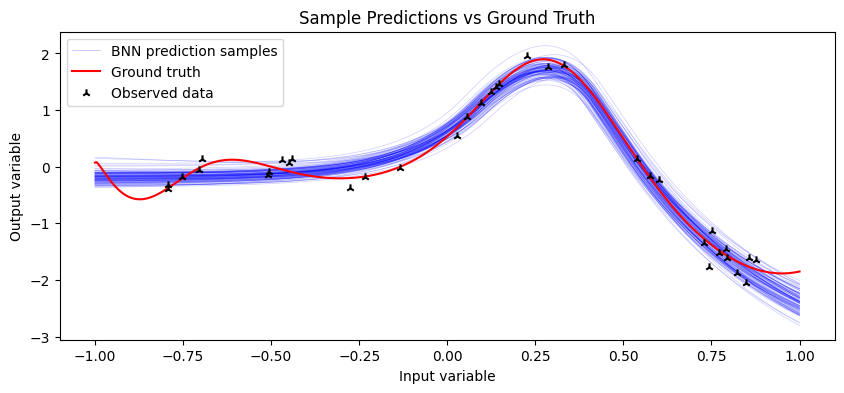

In [25]:
xs = np.linspace(-1, 1, 500)
num_samps = 100

preds = pre_train_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps).squeeze(-1).detach().numpy()
plt.plot(xs, preds[0,...], color='blue', linewidth=0.5, alpha=0.3, label='BNN prediction samples')
plt.plot(xs, preds[1:,...].T, color='blue', linewidth=0.5, alpha=0.2)

ys = normalised_ground_truth(xs)
plt.title("Sample Predictions vs Ground Truth")
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

In [51]:
pre_trained_values = []

for layer in pre_train_model.network:  # Assuming 'model' is your network and 'layers' is the list of layers
    if isinstance(layer, MeanFieldLayer):  # Check if the layer is FullCovGaussianLayer
        # Collect the values of w_mu_q, w_log_var_q, b_mu_q, and b_log_var_q
        values = [
            layer.w_mu_q.reshape(-1),      # weight mean for the posterior distribution
            layer.w_log_var_q.reshape(-1), # weight log variance for the posterior distribution
            layer.b_mu_q,      # bias mean for the posterior distribution
            layer.b_log_var_q  # bias log variance for the posterior distribution
        ]
        # Append these values as a list to pre_trained_values
        pre_trained_values.append(values)

In [125]:
BNN = RouBLBNN(1, [4, 4], 1, noise_std=0.15, pre_trained_values=pre_trained_values)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(BNN)


RouBLBNN(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): FullCovGaussianLayer()
    (1): ELU(alpha=1.0)
    (2): FullCovGaussianLayer()
    (3): ELU(alpha=1.0)
    (4): FullCovGaussianLayer()
  )
)


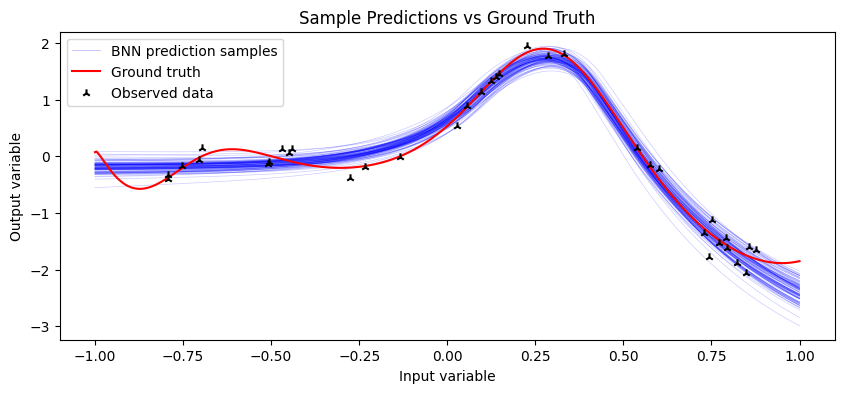

In [127]:
xs = np.linspace(-1, 1, 500)
num_samps = 100

preds = BNN(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps).squeeze(-1).detach().numpy()
plt.plot(xs, preds[0,...], color='blue', linewidth=0.5, alpha=0.3, label='BNN prediction samples')
plt.plot(xs, preds[1:,...].T, color='blue', linewidth=0.5, alpha=0.2)

ys = normalised_ground_truth(xs)
plt.title("Sample Predictions vs Ground Truth")
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()